In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Code_Injection_Dataset

/content/drive/MyDrive/Code_Injection_Dataset


In [ ]:
df_train = pd.read_csv('dataset_capec.csv')
df_train.head()

,text,label
0,GET /blog/index.php/2020/04/04/voluptatum-repr...,000 - Normal
1,GET /blog/xmlrpc.php?rsd,000 - Normal
2,GET /blog/index.php/2020/04/04/nihil-tenetur-e...,000 - Normal
3,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal
4,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal


66 - SQL Injection                        248093
000 - Normal                              226509
194 - Fake the Source of Data              55982
34 - HTTP Response Splitting               19134
126 - Path Traversal                       17595
242 - Code Injection                       13792
272 - Protocol Manipulation                 6924
310 - Scanning for Vulnerable Software      2382
153 - Input Data Manipulation               1387
Name: label, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '66 - SQL Injection'),
  Text(1, 0, '000 - Normal'),
  Text(2, 0, '194 - Fake the Source of Data'),
  Text(3, 0, '34 - HTTP Response Splitting'),
  Text(4, 0, '126 - Path Traversal'),
  Text(5, 0, '242 - Code Injection'),
  Text(6, 0, '272 - Protocol Manipulation'),
  Text(7, 0, '310 - Scanning for Vulnerable Software'),
  Text(8, 0, '153 - Input Data Manipulation')])

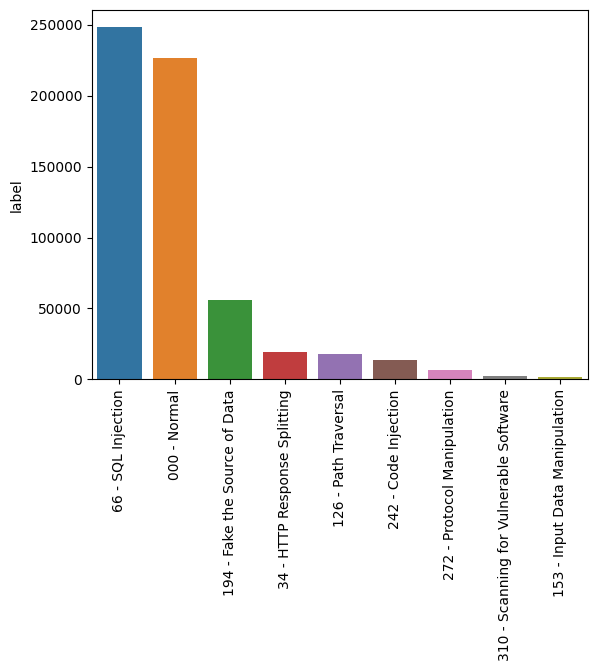

In [ ]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['label'].value_counts()
print(x)
sns.barplot(x = x.index, y = x)
plt.xticks(rotation=90)

# Create Feature Extraction Module (BOW and TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [ ]:
# Optional (not effect very much)
df_train['text'] = df_train['text'].str.replace('/',' ')
df_train.head()

,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


# TF-IDF Feature Extraction

## Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))




0.8681818181818182


In [ ]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.81      0.93      0.87     45261
                  126 - Path Traversal       1.00      0.80      0.89      3554
         153 - Input Data Manipulation       0.10      1.00      0.17       265
         194 - Fake the Source of Data       0.97      0.91      0.94     11239
                  242 - Code Injection       0.98      0.91      0.94      2829
           272 - Protocol Manipulation       0.00      0.00      0.00      1394
310 - Scanning for Vulnerable Software       0.92      0.28      0.43       468
          34 - HTTP Response Splitting       0.95      0.92      0.93      3890
                    66 - SQL Injection       0.94      0.83      0.88     49460

                              accuracy                           0.87    118360
                             macro avg       0.74      0.73      0.67    118360
                          weighted avg

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9600540723217303


In [ ]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45261
                  126 - Path Traversal       1.00      0.93      0.96      3554
         153 - Input Data Manipulation       0.32      0.08      0.13       265
         194 - Fake the Source of Data       1.00      0.93      0.96     11239
                  242 - Code Injection       1.00      0.99      0.99      2829
           272 - Protocol Manipulation       0.66      0.14      0.24      1394
310 - Scanning for Vulnerable Software       0.89      0.99      0.94       468
          34 - HTTP Response Splitting       1.00      1.00      1.00      3890
                    66 - SQL Injection       0.99      0.96      0.97     49460

                              accuracy                           0.96    118360
                             macro avg       0.86      0.78      0.79    118360
                          weighted avg

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.9602230483271376


In [ ]:
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45261
                  126 - Path Traversal       1.00      0.93      0.96      3554
         153 - Input Data Manipulation       0.50      0.01      0.02       265
         194 - Fake the Source of Data       1.00      0.93      0.96     11239
                  242 - Code Injection       1.00      0.99      1.00      2829
           272 - Protocol Manipulation       0.64      0.15      0.25      1394
310 - Scanning for Vulnerable Software       0.89      0.98      0.93       468
          34 - HTTP Response Splitting       1.00      1.00      1.00      3890
                    66 - SQL Injection       0.99      0.96      0.97     49460

                              accuracy                           0.96    118360
                             macro avg       0.88      0.77      0.78    118360
                          weighted avg

# AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10)
abc.fit(train_features, y_train)
print(abc.score(test_features, y_val))

0.5623436971949983


In [ ]:
y_predict = abc.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00     45261
                  126 - Path Traversal       0.00      0.00      0.00      3554
         153 - Input Data Manipulation       0.00      0.00      0.00       265
         194 - Fake the Source of Data       0.99      0.93      0.96     11239
                  242 - Code Injection       1.00      0.97      0.98      2829
           272 - Protocol Manipulation       0.00      0.00      0.00      1394
310 - Scanning for Vulnerable Software       0.00      0.00      0.00       468
          34 - HTTP Response Splitting       1.00      1.00      1.00      3890
                    66 - SQL Injection       0.49      1.00      0.66     49460

                              accuracy                           0.56    118360
                             macro avg       0.39      0.43      0.40    118360
                          weighted avg

## Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, y_train)
print(lr.score(test_features, y_val))


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9495860087867523


In [ ]:
y_predict = lr.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.91      0.98      0.94     45261
                  126 - Path Traversal       0.98      0.91      0.94      3554
         153 - Input Data Manipulation       0.29      0.01      0.01       265
         194 - Fake the Source of Data       0.99      0.93      0.96     11239
                  242 - Code Injection       1.00      0.97      0.99      2829
           272 - Protocol Manipulation       0.00      0.00      0.00      1394
310 - Scanning for Vulnerable Software       0.86      0.94      0.90       468
          34 - HTTP Response Splitting       1.00      1.00      1.00      3890
                    66 - SQL Injection       0.98      0.95      0.96     49460

                              accuracy                           0.95    118360
                             macro avg       0.78      0.74      0.75    118360
                          weighted avg

# BOW Feature Extraction

## Naive Bayes Classifier

In [ ]:
vectorizer = Vectorizer('BOW')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))

0.8295370057451842


In [ ]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.77      0.92      0.84     45261
                  126 - Path Traversal       0.99      0.90      0.94      3554
         153 - Input Data Manipulation       0.08      1.00      0.15       265
         194 - Fake the Source of Data       0.93      0.90      0.92     11239
                  242 - Code Injection       0.97      0.88      0.92      2829
           272 - Protocol Manipulation       0.04      0.06      0.05      1394
310 - Scanning for Vulnerable Software       0.79      0.37      0.50       468
          34 - HTTP Response Splitting       0.93      0.97      0.95      3890
                    66 - SQL Injection       0.96      0.74      0.84     49460

                              accuracy                           0.83    118360
                             macro avg       0.72      0.75      0.68    118360
                          weighted avg

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9603075363298411


In [ ]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45261
                  126 - Path Traversal       1.00      0.93      0.96      3554
         153 - Input Data Manipulation       0.60      0.01      0.02       265
         194 - Fake the Source of Data       1.00      0.93      0.96     11239
                  242 - Code Injection       1.00      0.99      1.00      2829
           272 - Protocol Manipulation       0.66      0.15      0.25      1394
310 - Scanning for Vulnerable Software       0.89      0.99      0.94       468
          34 - HTTP Response Splitting       1.00      1.00      1.00      3890
                    66 - SQL Injection       0.98      0.96      0.97     49460

                              accuracy                           0.96    118360
                             macro avg       0.89      0.77      0.78    118360
                          weighted avg

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.960442717134167


In [ ]:
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45261
                  126 - Path Traversal       1.00      0.93      0.96      3554
         153 - Input Data Manipulation       0.60      0.01      0.02       265
         194 - Fake the Source of Data       1.00      0.93      0.96     11239
                  242 - Code Injection       1.00      0.99      1.00      2829
           272 - Protocol Manipulation       0.64      0.16      0.25      1394
310 - Scanning for Vulnerable Software       0.89      0.99      0.94       468
          34 - HTTP Response Splitting       1.00      1.00      1.00      3890
                    66 - SQL Injection       0.99      0.96      0.97     49460

                              accuracy                           0.96    118360
                             macro avg       0.89      0.77      0.78    118360
                          weighted avg

## AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10)
abc.fit(train_features, y_train)
print(abc.score(test_features, y_val))

0.5623436971949983


In [ ]:
y_predict = abc.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00     45261
                  126 - Path Traversal       0.00      0.00      0.00      3554
         153 - Input Data Manipulation       0.00      0.00      0.00       265
         194 - Fake the Source of Data       0.99      0.93      0.96     11239
                  242 - Code Injection       1.00      0.97      0.98      2829
           272 - Protocol Manipulation       0.00      0.00      0.00      1394
310 - Scanning for Vulnerable Software       0.00      0.00      0.00       468
          34 - HTTP Response Splitting       1.00      1.00      1.00      3890
                    66 - SQL Injection       0.49      1.00      0.66     49460

                              accuracy                           0.56    118360
                             macro avg       0.39      0.43      0.40    118360
                          weighted avg

## Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, y_train)
print(lr.score(test_features, y_val))

In [ ]:
y_predict = lr.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

# Word2Vec Feature Extraction

In [ ]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)

In [ ]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [ ]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6198208854342684


In [ ]:
y_predict = clf.predict(X_test)
print(classification_report(y_test,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_test, y_predict))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.57      0.80      0.67     45581
                  126 - Path Traversal       0.31      0.08      0.13      3422
         153 - Input Data Manipulation       0.00      0.00      0.00       282
         194 - Fake the Source of Data       0.31      0.06      0.10     11048
                  242 - Code Injection       0.41      0.03      0.05      2786
           272 - Protocol Manipulation       0.00      0.00      0.00      1366
310 - Scanning for Vulnerable Software       0.70      0.93      0.80       475
          34 - HTTP Response Splitting       0.37      0.02      0.03      3790
                    66 - SQL Injection       0.70      0.72      0.71     49610

                              accuracy                           0.62    118360
                             macro avg       0.37      0.29      0.28    118360
                          weighted avg

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:
## importing all libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Case 1 : Would use Word2Vec and then apply different classifiers
from gensim.models import Word2Vec  

## Case 2 : Would use TfidfVectorizer and then apply different classifiers
from sklearn.feature_extraction.text import TfidfVectorizer   

## This would help us understand : Does the type of Vectorizing Process influence the precision , accuracy , recall score of the classifiers ??


from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# Classification using word2vec vectorizer
# Tokenize : dividing Sentences into words
df_train['text_clean'] = df_train['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

vec_model = Word2Vec(df_train['text_clean'])

w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))
## What is syn0 ?
## https://stackoverflow.com/questions/53301916/python-gensim-what-is-the-meaning-of-syn0-and-syn0norm

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


## for any Classifier , we need intialise the model with the parameters. 
## Further I am applying GridSearchCV for 5 runs (i.e 1/5th data used each time for testing) 
## So the model gets trained over 5 runs 
## as well we are predicting also over 5 runs
## In case if you wish to know about Cross Validation , you can watch my Video here : https://www.youtube.com/watch?v=LmxsySwAhoE&t=84s
class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)
    

## Preparing to make a pipeline 
clf_models = {
    'Naive Bayes': GaussianNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

clf_params = {
    'Naive Bayes': { }, 
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Random Forest': { },
    'AdaBoost': {  }
}


## splitting the dataset into 80:20.  have kept shuffle=True , so that the data is randomly sampled or simply said shuffled , and then split.
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.2, shuffle=True)

## for loop traverses , each and every classifier and its corresponding parameters.
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)  ## Note : we are calling user defined fit method. This fit method uses Cross Validation
    y_pred = clf.predict(X_test)  ## Note : we are calling user defined predict method. This predict method uses Cross Validation
    
    ## printing performance metrics for each classifier 
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    print('Confusion Matrix: \n',confusion_matrix(y_test, y_pred))

Tokenization complete.
Naive Bayes :
Accuracy: 0.482 	Precision: 0.370 	Recall: 0.636 		F1: 0.373

Confusion Matrix: 
 [[ 5007   522   544  4900  1013 12479 12368  3424  5040]
 [   34  1724    29    65  1306    89   174     8    20]
 [    1     0   223    15     0     2     8     0     0]
 [  289   206   557  7688   246   876   488   579   152]
 [   37    46    15   237  2390     4     0    31    80]
 [  219     4    57    50     0   342   689     2    39]
 [    5     1     0     4     0    24   467     0     1]
 [  230     0   156   239     1    71    26  2982   112]
 [ 3193   745   688  2789   645  2100  1065  2308 36190]]
Decision Tree :
Accuracy: 0.940 	Precision: 0.808 	Recall: 0.756 		F1: 0.777

Confusion Matrix: 
 [[43562    67    54   304    36   237    34   101   902]
 [  148  3224     6     9     6    11     9     0    36]
 [   59     2    51    34     0     5     0     0    98]
 [  879    15    46  9738    36    62     4    19   282]
 [   81     8     0    65  2611     3    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2b26577c42b5>", line 71, in <cell line: 67>
    clf.fit(X_train, y_train)  ## Note : we are calling user defined fit method. This fit method uses Cross Validation
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-17-2b26577c42b5>", line 40, in fit
    return self.gs.fit(X, y)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py", line 909, in fit
    self.best_estimator_.fit(X, y, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 473, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__